# In-Class Lab: A/B Testing on a Marketing Campaign

### Part 1: Data Exploration and Preparation
#### Step 1: Load the Data
* Load the provided dataset and inspect the first few rows to understand its structure.
* Check for any missing values in the dataset.
* Verify the data types of each column.

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("./ab_data.csv")

In [3]:
print(data.head())

   user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1


In [4]:
missing_values = data.isnull().sum()
print(missing_values)

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64


In [5]:
data_types = data.dtypes
print(data_types)

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object


### Step 2: Data Cleaning
* Identify if there are any duplicate users (i.e., users who appear in both the
Control and Test groups).
* If duplicates are found, remove them from the dataset to ensure the test’
integrity.

In [6]:
duplicate_users = data[data.duplicated(subset=["user_id"], keep=False)]["user_id"]
print(duplicate_users)

22        767017
192       656468
226       773693
240       733976
246       704650
           ...  
294308    905197
294309    787083
294328    641570
294331    689637
294355    744456
Name: user_id, Length: 7788, dtype: int64


In [7]:
data = data[~data["user_id"].isin(duplicate_users)]

#### Step 3: Descriptive Statistics
* Calculate basic summary statistics (e.g., mean, median) for conversion rates, page views, and session time.
* Group the data by landing page and display the average conversion rate for each group.

In [9]:
conversion_rates = data.groupby("group")["converted"].mean()
print(conversion_rates)

group
control      0.120173
treatment    0.118726
Name: converted, dtype: float64


In [10]:
page_views = data['landing_page'].value_counts()
print(page_views)

landing_page
new_page    143397
old_page    143293
Name: count, dtype: int64


In [11]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
session_times = data['timestamp'].agg(['min', 'median', 'max'])
print(session_times)

min      2017-01-02 13:42:05.378582000
median   2017-01-13 13:23:05.960603648
max      2017-01-24 13:41:54.460509000
Name: timestamp, dtype: datetime64[ns]


In [12]:
average_conversion_rate = data.groupby('landing_page')['converted'].mean()
print(average_conversion_rate)

landing_page
new_page    0.118726
old_page    0.120173
Name: converted, dtype: float64


### Part 2: Hypothesis Formulation
#### Step 1: Define Hypotheses
* Based on the dataset, define your null and alternative hypotheses.
  * **Null Hypothesis (H₀)**: There is no significant difference in conversion rates between the Control and Test groups. (μ₁ = μ₂)
  * **Alternative Hypothesis (H₁)**: There is a significant difference in conversion rates between the two groups. (μ₁ ≠ μ₂)

#### Step 2: Data Visualization
* Create a bar plot that visualizes the conversion rates for the Test and Control groups.
* Interpret the differences (if any) in conversion rates between the two groups.

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

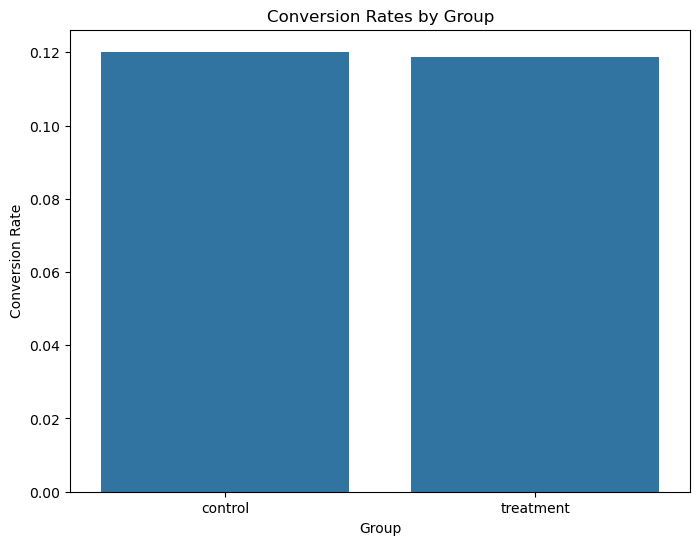

In [15]:
plt.figure(figsize=(8, 6))
sns.barplot(x=conversion_rates.index, y=conversion_rates.values)
plt.xlabel('Group')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates by Group')
plt.show()

### Part 3: A/B Testing (Two-Proportion Z-Test)
#### Step 1: Perform a Two-Proportion Z-Test
* Using the dataset, calculate the conversion rates for both the Control and Test groups.
* Perform a two-proportion z-test to determine whether the difference in conversion rates between the Control and Test groups is statistically
significant.
* Record the z-statistic and p-value from the test.

In [16]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

In [17]:
control_conversions = data[data['group'] == 'control']['converted'].sum()
control_total = len(data[data['group'] == 'control'])
test_conversions = data[data['group'] == 'treatment']['converted'].sum()
test_total = len(data[data['group'] == 'treatment'])

In [18]:
count = np.array([control_conversions, test_conversions])
nobs = np.array([control_total, test_total])
z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')

In [19]:
print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_value}")

Z-statistic: 1.1944850812796501
P-value: 0.23228827305833621


### Step 2: Interpretation
* Based on the p-value, decide whether to reject or fail to reject the null hypothesis.
* Discuss the business implications of your findings—should the company switch to the new landing page?

Since p-value > 0.05, failed to reject the null hypothesis: There is no significant difference in conversion rates between the Control and Test groups.
The company should not switch landing pages because of the development, testing, and deployment costs involved in switching to a new landing page.

### Part 4: Confidence Intervals and Visualization
#### Step 1: Confidence Intervals
* Calculate the 95% confidence intervals for the conversion rates of both the Test and Control groups.
* Discuss what the confidence intervals indicate about the reliability of the results.

In [21]:
from statsmodels.stats.proportion import proportion_confint

In [22]:
control_ci = proportion_confint(control_conversions, control_total, alpha=0.05)
test_ci = proportion_confint(test_conversions, test_total, alpha=0.05)

In [23]:
print(f"Control Group 95% Confidence Interval: {control_ci}")
print(f"Test Group 95% Confidence Interval: {test_ci}")

Control Group 95% Confidence Interval: (0.11848975370956265, 0.1218569485019899)
Test Group 95% Confidence Interval: (0.11705213455633105, 0.12040053181744247)


The substantial overlap in the confidence intervals indicates that the observed difference in conversion rates may be due to chance, and further investigation is warranted.

#### Step 2: Visualization of Confidence Intervals
* Create a plot that shows the conversion rates for both groups, including the confidence intervals as error bars.

In [24]:
groups = ['Control', 'Test']
conversion_rates = np.array([control_conversions / control_total, test_conversions / test_total])
error = np.array([(control_ci[1]-control_ci[0])/2, (test_ci[1]-test_ci[0])/2])

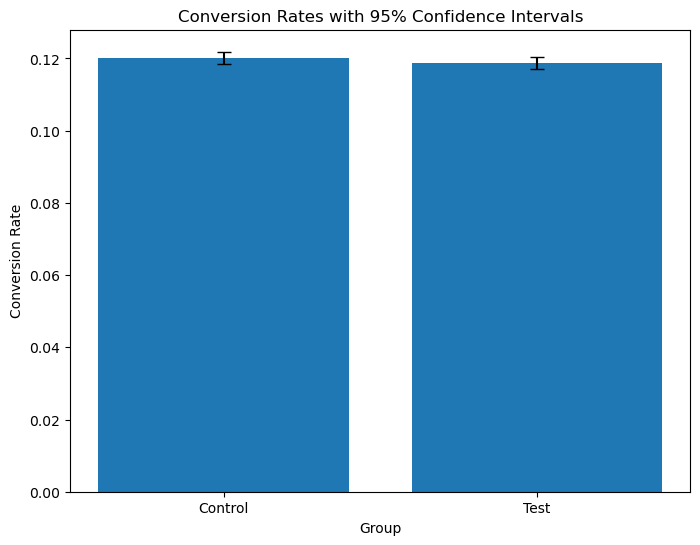

In [25]:
plt.figure(figsize=(8, 6))
plt.bar(groups, conversion_rates, yerr=error, capsize=5)
plt.xlabel('Group')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates with 95% Confidence Intervals')
plt.show()

### Part 5: Subgroup Analysis
#### Step 1: Time-Based Analysis
* Using the timestamp data, extract the hour of the day that each user visited the website.
* Group the data by hour and calculate the conversion rates for each hour.
* Create a line plot that shows how conversion rates vary by the time of day.

In [26]:
data['hour'] = data['timestamp'].dt.hour

In [27]:
hourly_conversion_rates = data.groupby('hour')['converted'].mean()

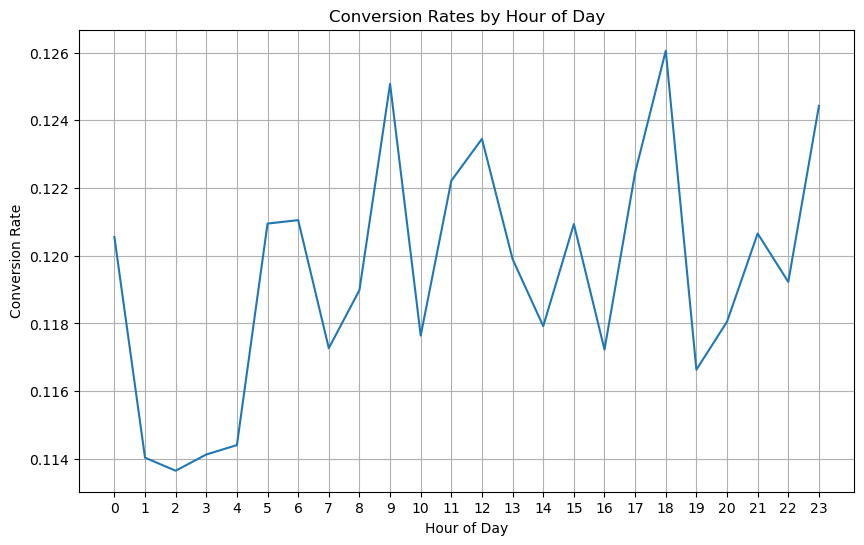

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(hourly_conversion_rates.index, hourly_conversion_rates.values)
plt.xlabel('Hour of Day')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates by Hour of Day')
plt.xticks(range(24))
plt.grid(True)
plt.show()

#### Step 2: Interpretation
* Analyze the conversion rate trends over different times of day.
* Identify if there are any specific time periods where the new landing page was more or less effective.

Conversion rates tend to be low between 1 pm and 4 pm, when people are sleeping, and high at 9 am and 6 pm, during commuting hours, 12 pm during lunch break, and 11 pm before bed.

In [31]:
hourly_conversion_by_page = data.groupby(['hour', 'landing_page'])['converted'].mean().unstack()

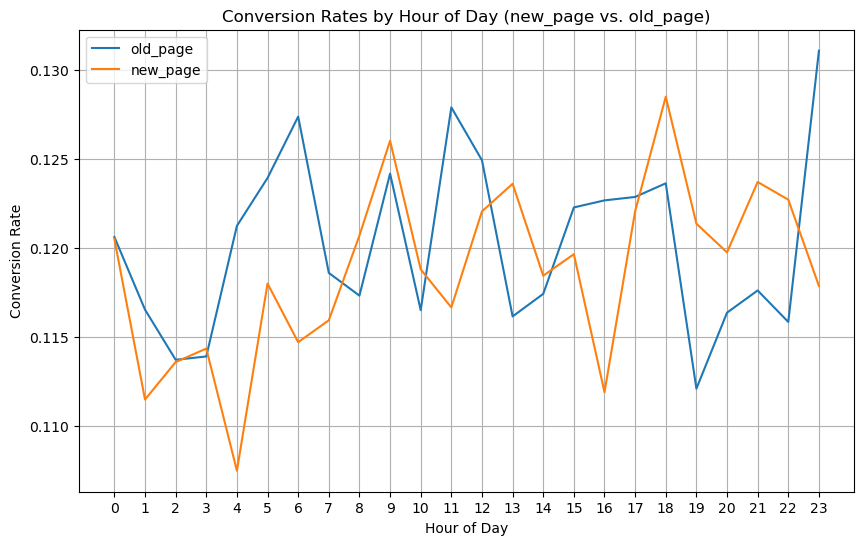

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(hourly_conversion_by_page.index, hourly_conversion_by_page['old_page'], label='old_page')
plt.plot(hourly_conversion_by_page.index, hourly_conversion_by_page['new_page'], label='new_page')
plt.xlabel('Hour of Day')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates by Hour of Day (new_page vs. old_page)')
plt.xticks(range(24))
plt.legend()
plt.grid(True)
plt.show()


New page conversion rates tend to be lower between 4 am and 7 am, while new page conversion rates tend to be higher between 6 pm and 10 pm.

### Part 6: Conclusion
#### Step 1: Summarize Findings
* Summarize the results of your A/B test, including whether the new landing page showed a statistically significant improvement in conversion rates.
* Discuss any additional insights gained from the confidence intervals and subgroup analysis.

AB testing was performed on the conversion rates of the old landing page and the new landing page, and no significant differences in conversion rates were found.

However, when the conversion rates were compared by time of day, there was a tendency for the conversion rate to differ between early morning and evening, so there is a possibility that a significant difference could be observed when AB testing is performed by limiting the time of day.

#### Step 2: Recommendations
* Based on your analysis, recommend whether the company should adopt the new landing page.
* Highlight any potential limitations of the A/B test, such as sample size, duration of the test, or external factors.

The company should not adopt the new landing page at this time because there is no statistical evidence that adopting the new landing page will increase conversion rates.

The data provided does not include factors that would change the conversion rate, so the company can use user demographics such as age, gender, location, and satisfaction to explore ways to increase the conversion rate.